# Example: Let's Play around with Modern Hopfield Networks
In this example, we explore encoding and retrieving multiple __continuous__ patterns using modern Hopfield Networks. In the previous example, we considered classical Hopfield networks with binary patterns. In this example, we extend these ideas to modern Hopfield networks that can store and retrieve continuous (grayscale) patterns.

> __Learning Objectives:__
> 
> By the end of this example, you should be able to:
> * **Encode multiple continuous patterns into a modern Hopfield network**: Apply the modern Hopfield network formulation to compute network parameters from multiple grayscale images and understand how patterns are stored in the memory matrix.
> * **Retrieve corrupted patterns from a modern Hopfield network**: Implement the softmax-weighted update algorithm to recover stored patterns from noisy or partial initial states by iteratively computing probability-weighted memory combinations.
> * **Analyze the role of the inverse temperature parameter**: Evaluate how the inverse temperature $\beta$ affects retrieval sharpness and convergence behavior, and observe the probability distribution over stored memories during retrieval.

Let's get started!
___

## Background: Modern Hopfield Networks
A modern Hopfield network addresses many of the perceived limitations of the classical Hopfield network. The classical Hopfield network was limited to binary values and could only store approximately $0.138N$ patterns. The modern Hopfield network uses continuous values and can store exponentially more patterns.

> __Why modern Hopfield networks?__
>
> * __Continuous patterns__: Modern Hopfield networks can store and retrieve continuous-valued patterns (such as grayscale images) rather than just binary patterns. This makes them suitable for a much wider range of applications.
> * __Exponential storage capacity__: Unlike classical networks limited to $\sim 0.138N$ patterns, modern networks can store exponentially many memories in the number of neurons, dramatically increasing their practical utility.
> * __Faster convergence__: Modern Hopfield networks exhibit exponential convergence (typically 1–5 iterations) rather than the polynomial convergence of classical networks.
>
> For a detailed discussion of the key milestones in the development of modern Hopfield networks, check out [Hopfield Networks is All You Need Blog, GitHub.io](https://ml-jku.github.io/hopfield-layers/)

### Algorithm: Memory retrieval
The user provides a set of memory vectors $\mathbf{X} = \left\{\mathbf{m}_{1}, \mathbf{m}_{2}, \ldots, \mathbf{m}_{K}\right\}$, where $\mathbf{m}_{i} \in \mathbb{R}^{N}$ is a memory vector of size $N$ and $K$ is the number of memory vectors. Further, the user provides an initial _partial memory_ $\mathbf{s}_{\circ} \in \mathbb{R}^{N}$, which is a vector of size $N$, and specifies the _inverse temperature_ $\beta$ of the system.

__Initialize__ the network with the memory matrix $\mathbf{X}$ and inverse temperature $\beta$. Set the current state $\mathbf{s} \gets \mathbf{s}_{\circ}$.

Until convergence __do__:
   1. Compute the _current_ probability vector $\mathbf{p} = \texttt{softmax}(\beta\;\mathbf{X}^{\top}\mathbf{s})$ where $\mathbf{s}$ is the _current_ state vector, and $\mathbf{X}^{\top}$ is the transpose of the memory matrix $\mathbf{X}$.
   2. Compute the _next_ state vector $\mathbf{s}^{\prime} = \mathbf{X}\mathbf{p}$ and the _next_ probability vector $\mathbf{p}^{\prime} = \texttt{softmax}(\beta\;\mathbf{X}^{\top}\mathbf{s}^{\prime})$.
   3. If $\lVert \mathbf{p}^{\prime} - \mathbf{p}\rVert_{1} \leq \epsilon$ for some small $\epsilon > 0$, or we run out of iterations, then __stop__.
   4. Otherwise, update the state $\mathbf{s} \gets\mathbf{s}^{\prime}$, and __go back to__ step 1.

This algorithm is implemented in [the `recover(...)` method](src/Compute.jl).

____

## Setup, Data, and Prerequisites
We set up the computational environment by including the `Include.jl` file, loading any needed resources, such as sample datasets, and setting up any required constants.

> The `Include.jl` file also loads external packages, various functions that we will use in the exercise, and custom types to model the components of our problem. It checks for a `Manifest.toml` file; if it finds one, packages are loaded. Other packages are downloaded and then loaded.

In [1]:
include("Include.jl"); # load a bunch of libs, including the ones we need to work with images

In [2]:
file_extension(file::String) = file[findlast(==('.'), file)+1:end]; # helper function to get the file extension

### Load the Simpsons characters dataset
In this example, we use a modern Hopfield network to memorize and retrieve image patterns from [the Simpsons character library from Kaggle](https://www.kaggle.com/datasets/kostastokis/simpsons-faces). We will encode selected character images into the network and then test whether the network can recover each image from a corrupted initial state.

Let's first set some constants that define the problem size and dataset parameters. The comment next to each constant describes its purpose, units, and values:

In [ ]:
number_of_images_to_memorize = 24; # how many images do we want to memorize?
number_digit_array = range(0,length=10,step=1) |> collect; # numbers 0 ... 9
number_of_rows = 200; # number of rows in the image
number_of_cols = 200; # number of cols in the image
number_of_pixels = number_of_rows*number_of_cols; # how many pixels do we have in the image?
β = 100.0; # Inverse temperature of the system. 

The code block below loads all training images from the dataset directory and stores them in the `training_image_dictionary::Dict{Int64, Array{Gray{N0f8},2}}` variable as a dictionary where images are indexed by their integer key.

In [4]:
training_image_dictionary = let
    training_image_dictionary = Dict{Int64, Array{Gray{N0f8},2}}();
    files = readdir(joinpath(_PATH_TO_IMAGES)); 
    number_of_files = length(files);
    imagecount = 1;
    for i ∈ 1:number_of_files
        filename = files[i];
        ext = file_extension(filename)
        if (ext == "png")
            training_image_dictionary[imagecount] = joinpath(_PATH_TO_IMAGES, filename) |> x-> FileIO.load(x) |> img-> Gray.(img); # convert to grayscale
            imagecount += 1
        end
    end
    training_image_dictionary
end;

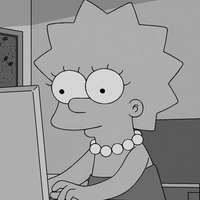

In [5]:
training_image_dictionary[719]

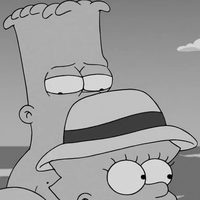

In [6]:
img = training_image_dictionary[2] # TODO: pick an example image. We have 1000 images to choose from!

Next, we convert the images from matrix format to vector format for network processing.

> * __Why vectorize?__ Each $n\times n$ image array containing grayscale pixel values is flattened into a vector of length $n^2$ by concatenating pixel values in row-major order. This vector representation is required for the Hopfield network, which operates on flattened input patterns.
> * __Floating-point precision:__ Most neural network libraries use `Float32` (single precision) rather than `Float64` (double precision) to reduce memory requirements and improve computational speed. This is especially important for large-scale networks and when using specialized hardware such as [Graphical Processing Units (GPUs)](https://www.nvidia.com/en-us/data-center/h100/).

The vectorized training data will be stored in the `training_image_dataset::Dict{Int, Vector{Float32}}` variable.

In [7]:
training_image_dataset = let
    training_image_dataset = Dict{Int, Vector{Float32}}();
    number_of_training_examples = length(training_image_dictionary);
    for t ∈ 1:number_of_training_examples
        X = training_image_dictionary[t];
        D = Array{Float32,1}(undef, number_of_pixels);
        linearindex = 1;
        for row ∈ 1:number_of_rows
            for col ∈ 1:number_of_cols
                D[linearindex] = X[row,col];
                linearindex+=1;
            end
        end
        training_image_dataset[t] = D;
    end
    training_image_dataset
end;

In [8]:
training_image_dataset[719]

40000-element Vector{Float32}:
 0.5764706
 0.5764706
 0.5764706
 0.5764706
 0.5764706
 0.5764706
 0.5764706
 0.5803922
 0.5803922
 0.5803922
 ⋮
 0.38039216
 0.38039216
 0.38039216
 0.38039216
 0.38039216
 0.38039216
 0.38039216
 0.38431373
 0.15294118

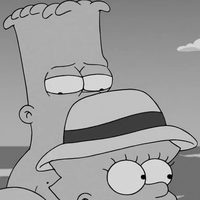

In [9]:
training_image_dataset[2] |> s-> decode(s, number_of_rows=number_of_rows,number_of_cols=number_of_cols) |> img -> Gray.(img)

In [10]:
training_image_dataset[10]

40000-element Vector{Float32}:
 0.44705883
 0.44705883
 0.4509804
 0.4509804
 0.45490196
 0.45490196
 0.45882353
 0.14901961
 0.019607844
 0.3764706
 ⋮
 0.44705883
 0.44705883
 0.4509804
 0.4509804
 0.4509804
 0.4509804
 0.4509804
 0.4509804
 0.4509804

___

## Task 1: Encode a Modern Hopfield Network Model
In this task, we'll encode the image dataset into a modern Hopfield network model. We'll compute the memory matrix and store it [in an instance of the `MyModernHopfieldNetworkModel` type](src/Types.jl).

Next, let's generate a random set of image indexes that we encode into the model. We'll store this collection in the `image_index_set_to_encode::Set{Int64}` variable.
> __How do we build this set?__ We specify the number of images that we want in the `number_of_images_to_memorize::Int` variable; then we iterate using [a `while-loop`](https://docs.julialang.org/en/v1/base/base/#while) until we generate the required number of indexes _randomly_. We stop the loop once we hit our target number. Fun data structure question: why do we use [a Julia `Set`](https://docs.julialang.org/en/v1/base/collections/#Base.Set) instead of an array?

The code block below shows how we generate a random set of image indices to encode into the network.

In [11]:
image_index_set_to_encode = let

    # how many images do we want to encode?
    number_of_possible_images = length(training_image_dataset);
    image_index_set_to_encode = Set{Int64}();

    is_ok_to_stop = false; # iteration flag
    while (is_ok_to_stop == false)
        
        # generate a random index -
        j = rand(1:number_of_possible_images);
        push!(image_index_set_to_encode, j); # add to the image set -

        # check: have we hit the number that we want?
        if (length(image_index_set_to_encode) ≥ number_of_images_to_memorize)
            is_ok_to_stop = true;
        end
    end

    # return 
    image_index_set_to_encode;
end;

In [12]:
image_index_set_to_encode |> collect |> sort

24-element Vector{Int64}:
  90
  99
 152
 157
 211
 225
 242
 249
 259
 303
   ⋮
 834
 838
 874
 893
 903
 910
 940
 945
 977

### Normalize and encode the memory matrix
Before encoding the memory matrix, we center and normalize each image vector. This step helps improve the network's performance during retrieval.

> __What is centering and normalization?__ Centering involves subtracting the mean pixel value from each pixel in the image vector, resulting in a zero-mean vector. Normalization scales the vector to have a unit norm (length of 1). This process ensures that all images contribute equally to the memory matrix, preventing any single image from dominating due to its brightness or contrast.

Let's mess around with the normalization process and encode the memory matrix into the modern Hopfield network model. 

In [13]:
flattened_normalized_memory_dictionary = let

    # initialize
    flattened_normalized_memory_dictionary = Dict{Int64, Vector{Float32}}();
    ϵ = 1e-12; # small number to avoid division by zero

    for i ∈ image_index_set_to_encode
        s = training_image_dataset[i]; # uncentered, unnormalized image vector

        # center and normalize the image vector
        s_mean = mean(s);
        s_centered = s .- s_mean; # center
        s_normalized = s_centered ./ (norm(s_centered, 2) + ϵ); # normalize

        # store
        flattened_normalized_memory_dictionary[i] = s_normalized;
    end

    flattened_normalized_memory_dictionary;
end

Dict{Int64, Vector{Float32}} with 24 entries:
  448 => [0.00297729, 0.00277803, 0.00277803, 0.00277803, 0.00277803, 0.0027780…
  874 => [-0.000611916, -0.000611916, -0.000507046, -8.75662f-5, -0.000821657, …
  910 => [-0.00117388, -0.00117388, -0.00117388, -0.00117388, -0.00117388, -0.0…
  945 => [0.00478257, 0.00478257, 0.00478257, 0.0046898, 0.0046898, 0.0046898, …
  99  => [0.00219695, 0.00227003, 0.00227003, 0.0023431, 0.0023431, 0.00227003,…
  838 => [0.00238849, 0.00238849, 0.00238849, 0.00238849, 0.00238849, 0.0023884…
  319 => [0.00516987, 0.00516987, 0.00516987, 0.00505799, 0.00550552, 0.0039391…
  834 => [0.00021398, 0.00021398, 0.00021398, 0.00021398, 0.00021398, 0.0002139…
  670 => [0.000612041, 0.000512876, 0.000413712, 0.0010087, 0.00140536, -8.2112…
  90  => [-0.00273277, -0.00273277, -0.00273277, -0.00273277, -0.00273277, -0.0…
  303 => [-0.00642972, -0.00653794, -0.00642972, -0.00653794, -0.00653794, -0.0…
  903 => [-0.0067974, -0.0067974, -0.0067974, -0.00695041, -0.0

### Encode a modern Hopfield model
Now that we have the training images, let's encode the model. We'll construct [a `MyModernHopfieldNetworkModel` instance](src/Types.jl) using a custom [`build(...)` function](src/Factory.jl). 

> __How do we build this model?__ We build the model using [the `build(...)` method](src/Factory.jl). This method takes the type of thing we want to construct, namely [a `MyModernHopfieldNetworkModel` instance](src/Types.jl), the (linearized) image library we want to encode, and the inverse temperature $\beta$ as inputs. The [`build(...)` method](src/Factory.jl) returns a model instance with the `X` (memory matrix) and `β` (inverse temperature) fields populated.

Let's store the encoded model in the `model::MyModernHopfieldNetworkModel` variable.

In [14]:
model = let

    # initialize -
    number_of_images_to_learn = length(image_index_set_to_encode);
    linearimagecollection = Array{Float32,2}(undef, number_of_pixels, number_of_images_to_learn); # images on columns
    normalized_linear_image_collection = Array{Float32,2}(undef, number_of_pixels, number_of_images_to_learn); # images on columns
    index_vector = image_index_set_to_encode |> collect |> sort; # # turn our set into a sorted vector - we'll process this in the sorted order 
    


    # populate the data array that we give to the model
    for k ∈ eachindex(index_vector)
        j = index_vector[k]; # what image index will we load?
        sₖ = training_image_dataset[j] # load 
        ŝₖ = flattened_normalized_memory_dictionary[j] # load normalized version
        
        for i ∈ 1:number_of_pixels
            linearimagecollection[i,k] = sₖ[i];  # fill the columns of the array with the image data
            normalized_linear_image_collection[i,k] = ŝₖ[i]; # fill the columns of the array with the normalized image data
        end
    end
    
    # build model -
    model = build(MyModernHopfieldNetworkModel, (
            memories = linearimagecollection, # this is the data we want to memorize. Images on columns
            normalized_memories = normalized_linear_image_collection, # normalized images on columns
            β = β, # Inverse temperature of the system. A big beta means we are more likely to get the right answer
    ));

    model; # return the model to the calling scope
end;

__Check__: Let's do a quick check to make sure we are doing what we think we are doing. Let's check what's stored in the columns of the `model.X` field. These should be the images that we are trying to encode.

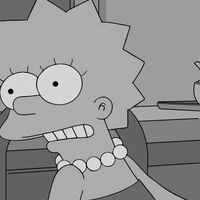

In [15]:
let
    X = model.X; # get the training data in the model
    index_to_check = 4; # what index do we want to check?
    X[:,index_to_check] |> s-> decode(s, number_of_rows = number_of_rows, 
        number_of_cols = number_of_cols) |> img -> Gray.(img) # decode (turn back into a array) and display
end

___

## Task 2: Retrieve a memory from the network
In this task, we will retrieve a memory from the modern Hopfield network starting from a corrupted state vector $\mathbf{s}_{\circ}$. Let's start by specifying which of the images we expect to recover in the `imageindextorecover::Int` variable.

In [16]:
imageindextorecover = 4; # which element of the index vector will we choose?

Next, we'll build a corrupted initial condition vector $\mathbf{s}_{\circ}$ based on a selected memorized image. This vector will serve as the starting point for the memory recovery algorithm. We initialize the state vector by copying the original image and then systematically corrupt a fraction of the pixels to simulate noisy input.

> __The $\theta$ corruption parameter:__ The parameter $\theta \in [0,1]$ controls the fraction of pixels we preserve from the original image. Specifically, we keep the first $(1-\theta)\cdot{N}$ pixels from the correct image and set the remaining $\theta\cdot{N}$ pixels to $0$, simulating damage or noise in the input. For example, if $\theta = 0.05$, we preserve 95% of the original pixel values and corrupt the remaining 5%, creating a noisy version of the true image that the network must restore.

Let's compute the corrupted initial condition vector `sₒ::Array{Float32,1}`.

In [17]:
 ŝₒ,sₒ = let

    # initialize -
    index_vector = image_index_set_to_encode |> collect |> sort; # we'll process this in this order
    index_of_image_to_encode = index_vector[imageindextorecover]; # we are going to use this image index as the starting point
    
    
    ŝₖ = flattened_normalized_memory_dictionary[index_of_image_to_encode]; # raw state in vector form (correct at this point)
    sₖ = training_image_dataset[index_of_image_to_encode]; # raw state in vector form (correct at this point)
    sₒ = Array{Float32,1}(undef, number_of_pixels); # initialize some space to store the corrupted image
    ŝₒ = Array{Float32,1}(undef, number_of_pixels); # initialize some space to store the corrupted image
    θ = 0.55; # threshold (fraction 1 - θ is fraction original in cutoff image case)


    # Model 1: Cutoff part of the *normalized* image
    cutoff = (1-θ)*number_of_pixels |> x-> round(Int,x);
    for i ∈ 1:number_of_pixels
        pixel =  ŝₖ[i]; # We have some gray-scale values in the original vector, need to perturb
        if (i ≤ cutoff)
            ŝₒ[i] = pixel;
        else
            ŝₒ[i] = 0.0;
        end
    end

    # Model 2: Cutoff part of the *original* image
    cutoff = (1-θ)*number_of_pixels |> x-> round(Int,x);
    for i ∈ 1:number_of_pixels
        pixel =  sₖ[i]; # We have some gray-scale values in the original vector, need to perturb
        if (i ≤ cutoff)
            sₒ[i] = pixel;
        else
            sₒ[i] = 0.0;
        end
    end;
    
    ŝₒ,sₒ # return corrupted data to the calling scope
end;

What does the initial state vector $\mathbf{s}_{\circ}$ look like (this should be a corrupted version of the `imageindextorecover` image):

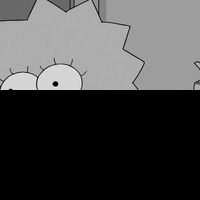

In [18]:
decode(sₒ, number_of_rows = number_of_rows, 
    number_of_cols = number_of_cols) |> img -> Gray.(img) # corrupted true image. This is what *we give the network*

Now that we have a corrupted initial state $\mathbf{s}_{\circ}$, can the network recover the original image?

> __Expected behavior:__ The softmax-weighted update algorithm iteratively computes probability distributions over stored memories and updates the state as a weighted combination of memories. At each step, we record the network state and probability vector. The algorithm should converge toward the most similar stored pattern. We expect the probability distribution to sharpen as the network evolves, eventually concentrating on a single memory.

The recovery algorithm has been implemented in [the `recover(...)` method](src/Compute.jl). This method accepts:
- `model::MyModernHopfieldNetworkModel`: The encoded modern Hopfield network with stored memories
- `sₒ::Array{Float32,1}`: The corrupted initial state vector
- `maxiterations::Int64`: Maximum number of update steps to perform (optional: default is `1000`)
- `ϵ::Float64`: Convergence tolerance for probability vector changes (optional: default is `1e-6`)

The method returns:
- `s₁::Array{Float32,1}`: The final recovered state vector
- `f::Dict{Int, Array{Float32,1}}`: A dictionary mapping iteration index to the network state at that iteration
- `p::Dict{Int, Array{Float32,1}}`: A dictionary mapping iteration index to the probability vector at that iteration

Call [the `recover(...)` method](src/Compute.jl) below to perform memory retrieval from the corrupted initial state.

In [19]:
(ŝᵢ,f,p) = recover(model, ŝₒ, maxiterations = 10000, ϵₚ = 1e-12, ϵₛ = 1e-12); # iterate until we hit stop condition

In [20]:
println("How many iterations: $(length(f))") # how many iterations did we need to converge?

How many iterations: 28


In [21]:
p[length(f) - 1] # probability of each memory at iteration at the last iteration

24-element Vector{Float64}:
 0.00025478150200568587
 0.971120755393569
 0.0008373156851326778
 0.0011326058349525568
 0.0010722716987925946
 4.769940682274041e-5
 0.002382135963798028
 0.0013677455396155413
 0.008194303927898283
 0.0001419127136273886
 ⋮
 0.0011018279835538704
 0.00043697117228243493
 1.6564077639264984e-5
 0.002376678325995715
 0.0009373362797189383
 0.00028372102014792273
 0.00046828607078190437
 0.0008216676867652104
 0.0011870512962763684

Which image does the model recover? The code block below displays the recovered image.

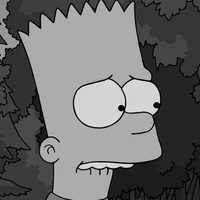

In [22]:
let
    # initialize - 
    i = argmax(p[length(f) - 1]); # which memory has the highest probability at the end of the iterations?
    X = model.X;
    x = X[:,i]; # get the memory with the highest probability
    decode(x, number_of_rows = number_of_rows, 
        number_of_cols = number_of_cols) |> img -> Gray.(img) # After n iterations, this is what the network gave us back
end

___

## Task 3: Understand the Role of the Inverse Temperature $\beta$
Sometimes the recovery works, and sometimes it doesn't. What is going on? Let's extract the iteration logic in [the `recover(...)` method](src/Compute.jl) and try to understand the role of the inverse temperature parameter $\beta$.

> __The softmax function and probability vectors:__
>
> The probability vector $\mathbf{p} = \texttt{softmax}(\beta\cdot\mathbf{X}^{\top}\mathbf{s})$ is computed using the [softmax function](https://en.wikipedia.org/wiki/Softmax_function). The softmax function takes a vector of real numbers and converts it into a probability distribution:
> $$
\begin{align*}
p_{i} = \texttt{softmax}(\mathbf{x})_{i} = \frac{\exp(x_{i})}{\sum_{j=1}^{K}\exp(x_{j})}\quad\forall i\in\{1,\ldots,K\}
\end{align*}
$$
> where $\mathbf{x}$ is the input vector, $p_{i}$ is the $i$-th element of the output vector, and $K$ is the number of stored memories.
>
> * __As the network's choice becomes more certain__: The probability vector $\mathbf{p}\rightarrow\mathbf{e}_{\star}$ converges to a one-hot vector describing the chosen image (a standard basis vector), indicating the network has "decided" on a specific memory.
> * __The probability vector as a mixing distribution__: The probability vector $\mathbf{p}$ describes the _mixing_ of the images in the library. It represents the weights in a weighted sum of possible memories, i.e., $\mathbf{s}^{\prime} = \mathbf{X}\mathbf{p}$.

Let's check out what is happening, especially as we increase/decrease the temperature $\beta$ parameter.

In [23]:
tmp, ptmp = let

    X̂ = model.X̂; # get the training data in the model (scaled)
    β = model.β; # temperature of the system

    tmp = 100*β*transpose(X̂)*ŝₒ;
    p = softmax(tmp)
    
    tmp,p
end;

Let's look at the choice after the first iteration:

In [24]:
ptmp

24-element Vector{Float64}:
 4.541940880827703e-110
 5.818760663581001e-84
 1.3485666084548889e-95
 1.0
 5.389472191433548e-101
 4.631410836171535e-127
 1.989172628159656e-92
 1.4412019478397976e-92
 3.213103981306894e-77
 4.451897361612514e-118
 ⋮
 1.883029471513005e-100
 9.865950393999477e-108
 6.896991843628813e-108
 2.832545593383048e-97
 8.495186682258776e-93
 4.5774300687611835e-107
 1.1612085702307839e-135
 2.0967875940526166e-129
 4.3436283447504096e-129

___

## Summary
This example explores encoding and retrieving multiple continuous patterns from modern Hopfield networks using softmax-weighted updates and energy-based optimization.

> __Key Takeaways:__
> 
> * **Continuous pattern storage:** Modern Hopfield networks store continuous (grayscale) patterns in a memory matrix, enabling retrieval of real-valued data rather than just binary patterns. The softmax-weighted update rule computes probability distributions over stored memories to guide convergence.
> * **Inverse temperature controls sharpness:** The inverse temperature parameter $\beta$ controls the sharpness of the probability distribution over memories. Higher $\beta$ values produce sharper distributions that converge more decisively to a single memory, while lower values produce softer mixing of multiple patterns.
> * **Exponential convergence:** Modern Hopfield networks typically converge within 1–5 iterations, dramatically faster than classical networks. The probability vector evolves toward a one-hot encoding as the network "decides" on the most similar stored pattern.

Modern Hopfield networks provide a powerful framework for continuous associative memory, bridging classical neural network theory with contemporary attention mechanisms in deep learning.

___